<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/05_text-generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
# !git clone https://github.com/rickiepark/nlp-with-transformers.git
# %cd nlp-with-transformers
# from install import *
# install_requirements()

In [2]:
from utils import *
setup_chapter()

2022-07-26 07:10:55.554080: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-26 07:10:55.554111: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Using transformers v4.11.3
Using datasets v1.16.1


# 텍스트 생성

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="images/chapter05_lm-meta-learning.png" id="lm-meta-learning"/>

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="images/chapter05_meena.png" id="meena"/>

## 일관성 있는 텍스트 생성의 어려움

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="images/chapter05_text-generation.png" id="text-generation"/> 

## 그리디 서치 디코딩

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
# 시스템의 메모리가 부족하거나 코랩의 경우 "gpt" 또는 "gpt2-large"를 사용하세요.
model_name = "gpt2-large"
# model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [4]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # 첫 번째 배치의 마지막 토큰의 로짓을 선택해 소프트맥스를 적용합니다.
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # 가장 높은 확률의 토큰을 저장합니다.
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # 예측한 다음 토큰을 입력에 추가합니다.
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (11.78%),best (6.66%),only (5.62%),first (2.91%),ultimate (2.23%)
1,Transformers are the most,popular (22.63%),successful (5.55%),famous (3.38%),powerful (3.14%),important (2.54%)
2,Transformers are the most popular,toys (8.87%),toy (7.88%),of (5.03%),Transformers (4.69%),franchise (3.88%)
3,Transformers are the most popular toys,of (31.69%),in (23.73%),ever (4.85%),", (4.50%)",for (3.58%)
4,Transformers are the most popular toys of,all (57.47%),the (21.31%),2015 (2.34%),their (1.66%),2014 (1.54%)
5,Transformers are the most popular toys of all,time (94.71%),- (1.86%),. (0.66%),", (0.56%)",times (0.52%)
6,Transformers are the most popular toys of all ...,. (34.98%),", (33.86%)",and (7.03%),! (2.16%),in (1.73%)
7,Transformers are the most popular toys of all ...,They (10.93%),\n (9.23%),The (6.63%),In (2.91%),And (2.68%)


In [5]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

Transformers are the most popular toys of all time. They


In [6]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David R. Williams of the University of California,
Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home


## 빔 서치 디코딩

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="images/chapter05_beam-search.png" id="beam-search"/> 

In [7]:
0.5 ** 1024

5.562684646268003e-309

In [8]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

In [9]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [10]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [11]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, led by Dr. David R. Williams of the University of California,
Santa Cruz, discovered the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home to a number of rare species of animals.


The researchers found the unicorns in the Andes Mountains of Peru. The area is
known for its unique geology and is home

로그 확률: -86.50


In [12]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz, and the University of California, Santa Cruz, and
published in the Journal of Mammalogy.


The team, led by Dr. David Hone of the University of California, Santa Cruz,
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains.




로그 확률: -65.20


In [13]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n로그 확률: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of researchers from the University of
California, Santa Cruz, and the National Geographic Society. The team was led by
Dr. Richard Wrangham, a professor of ecology and evolutionary biology at UCSC.

"We've known for a long time that there are animals that live in remote areas of
the world, but this is the first time we've been able

로그 확률: -79.02


## 샘플링 방법

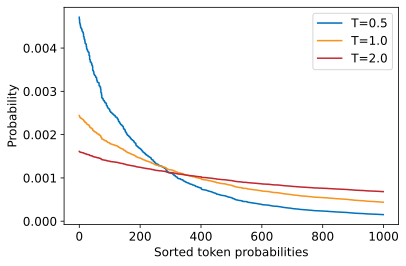

In [14]:
#온도의 함수로 표현한 토큰 확률
#세 개의 온도에서 랜덤하게 생성한 토큰 확률의 분포
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [15]:
torch.manual_seed(42);

In [16]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Sure fairy fá travellers Norval Bundy \(107 Zurich, Vice Laato Glad weighed Bear
Publishing berries flux∴ARE)." Takes Bear It AC versa Thomas Colomblees Sal
Meielvedr made Park Alexandria cost cdempp North car sm--- his Tunes shaken
concernhead irritating allocations bitters Looking instance inferred
investigation wond Shroud Mark satire efficacy Speech gniaz proposalsy fight
stocked Ald Victorian Ret Console TABLE Eyus Credit


In [17]:
torch.manual_seed(42);

In [18]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


"They were a little bit different than the other wild animals in the area," said
Dr. Jim Puckett, a professor of biology at the University of California,
Riverside. "They were a little bit more docile, a little bit more shy, and they
had a very different way of communicating."


The unicorns were discovered by a team of scientists who were conducting
research in the And


## 탑-k 및 뉴클리어스 샘플링

In [19]:
torch.manual_seed(42);

In [20]:
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [21]:
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

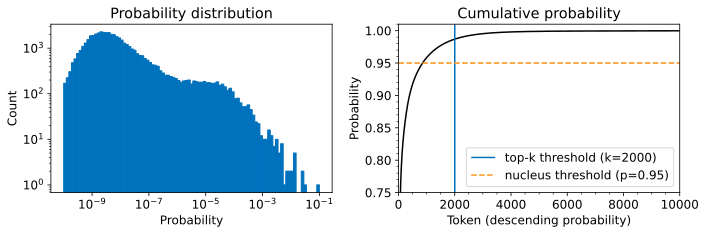

In [22]:
#다음 토큰 예측의 확률 분포
#다음 토큰 예측의 확률 분포(왼쪽)과 내림차순으로 정렬된 토큰 확률의 누적 분포

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [23]:
torch.manual_seed(42);

In [24]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


"They've been around here for millions of years," said lead researcher and
wildlife specialist, Dr Jim Prowse. "They're much more intelligent than we think
and they've adapted to their ecosystem very well. They've been there for
billions of years and have adapted to be able to survive under extreme
conditions."


The scientists studied the animals using a drone, fitted with a motion detector
called the


In [25]:
torch.manual_seed(42);

In [26]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


"They've been around here for millions of years," said lead researcher and
wildlife specialist, Dr. Carlos Eduardo Moreno. "But what we didn't expect was
that they were so fluent."


In addition to being fluent in English, the unicorns can also understand English
from a distance. They can understand the words of others as well, using gestures
and body language to communicate.


The


## 어떤 디코딩 방법이 최선일까요?

## 결론